%%

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np
import os
import shutil
from tensorflow.python.keras.regularizers import L2
from WGAN_GP import WGAN_GP

general functions

In [2]:
def load_data(batch_size):
    @ tf.function
    def parse_files(filename):
        image_string = tf.io.read_file(filename)
        image_decoded = tf.image.decode_jpeg(image_string, channels=3)
        image = tf.cast(image_decoded, tf.float32) / 127.5 - 1
        return image

    # ds= tf.data.Dataset.list_files('C:/Users/alans/tensorflow_datasets/celeb_a/img_align_celeba/*.jpg', shuffle=False)
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    x_train = x_train[np.where(y_train[:,0] == 2)]
    plt.imshow(x_train[50,:,:,:])
    x_train = x_train / 127.5 - 1
    x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
    ds = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000).batch(batch_size)
    # ds = ds.shuffle(len(ds)).map(parse_files)
    # ds = ds.batch(batch_size, drop_remainder=True)
    # ds = ds.prefetch(buffer_size=batch_size)
    
    return ds

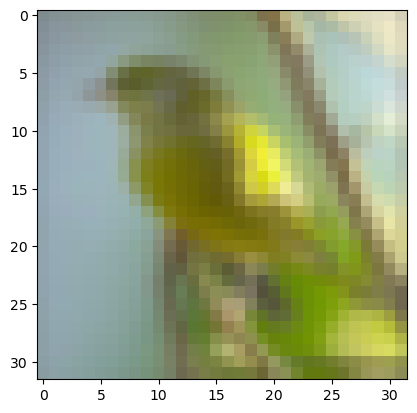

In [3]:
batch_size = 64
ds = load_data(batch_size)

%%

In [4]:
def bn_relu(x, useRelu=True):
    fx = layers.BatchNormalization()(x)
    if useRelu:
        fx = layers.LeakyReLU(0.3)(fx)
    return fx

In [5]:
def conv(x, filterNumb, kernel_size, strides=1, padding='same', use_bias=True):
    fx = layers.Conv2D(filterNumb, kernel_size, strides, padding=padding,
                    use_bias=use_bias)(x)
    return fx

In [6]:
def residual_block(x, filterNumb, isPooling=False):
    strides = 1
    shortcut = x
    bn_x = bn_relu(x)
    if isPooling:
        strides = (2,2)
        shortcut = conv(bn_x, filterNumb, kernel_size=1, strides=strides)
    fx = conv(bn_x, filterNumb, kernel_size=3, strides=strides)
    fx = bn_relu(fx)
    fx = conv(fx, filterNumb, kernel_size=3)
    out = layers.Add()([shortcut, fx]) # skip
    return out

In [7]:
def conv_transpose(model, kernels, strides, activation=None):
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.3))
    model.add(layers.Conv2DTranspose(kernels, (3, 3), strides=strides, padding='same', use_bias=False))   

In [8]:
def generate_image(gan_model, seed=None, isShow=True, isSaveFile=False):
    grid_size = (2,2)
    w, h = grid_size
    img_count = w * h
    if seed is None:
        seed = tf.random.normal(shape=(4, 1, 1, gan_model.seed_size))
    fake_img_batch = gan_model.generator(test_seed, training=False)
    fig = plt.figure(figsize=grid_size, dpi=70)
    fig.set_figheight(4)
    fig.set_figwidth(4)
    for i in range(img_count):
        plt.subplot(w, h, i+1)
        img = tf.cast(fake_img_batch[i, :, :, :] * 127.5 + 127.5, dtype='uint8')
        plt.imshow(img)
        plt.axis('off')
    if isShow: 
        plt.show()
    if isSaveFile:
        if not os.path.exists('./Results'):
            os.makedirs('./Results')
        plt.savefig('./Results/{:06d}.png'.format(gan_model.dis_opt.iterations.numpy()))
        
# models
def create_generator(seed_size):
    inputs = layers.Input(shape=(1, 1, seed_size))
    hx = layers.UpSampling2D(size=(4,4))(inputs)
    hx = conv(hx, seed_size, kernel_size=4)
    hx = layers.LeakyReLU(0.3)(hx)
    hx = conv(hx, seed_size, kernel_size=3)
    hx = layers.LeakyReLU(0.3)(hx)
    hx = layers.UpSampling2D(size=(2,2))(hx)
    hx = conv(hx, 64, kernel_size=3)
    hx = layers.LeakyReLU(0.3)(hx)
    hx = conv(hx, 64, kernel_size=3)
    hx = layers.LeakyReLU(0.3)(hx)
    hx = layers.UpSampling2D(size=(2,2))(hx)
    hx = conv(hx, 32, kernel_size=3)
    hx = layers.LeakyReLU(0.3)(hx)
    hx = conv(hx, 32, kernel_size=3)
    hx = layers.LeakyReLU(0.3)(hx)
    hx = layers.UpSampling2D(size=(2,2))(hx) 
    hx = conv(hx, 16, kernel_size=3)
    hx = layers.LeakyReLU(0.3)(hx)
    hx = conv(hx, 16, kernel_size=3)
    hx = layers.LeakyReLU(0.3)(hx)
    outputs = conv(hx, 3, kernel_size=1)
    outputs = layers.Activation('tanh')(outputs)
    model = tf.keras.Model(inputs, outputs, name="Generator")
    model.summary()
    return model

In [9]:
def create_discriminator():
    inputs = layers.Input(shape=(32, 32, 3))
    hx = conv(inputs, 16, kernel_size=1)
    hx = layers.LeakyReLU(0.3)(hx)
    hx = conv(hx, 16, kernel_size=3)
    hx = layers.LeakyReLU(0.3)(hx)
    hx = conv(hx, 32, kernel_size=3, strides=2)
    hx = layers.LeakyReLU(0.3)(hx)
    hx = conv(hx, 32, kernel_size=3)
    hx = layers.LeakyReLU(0.3)(hx)
    hx = conv(hx, 64, kernel_size=3, strides=2)
    hx = layers.LeakyReLU(0.3)(hx)
    hx = conv(hx, 64, kernel_size=3)
    hx = layers.LeakyReLU(0.3)(hx)
    hx = conv(hx, 128, kernel_size=3, strides=2)
    hx = layers.LeakyReLU(0.3)(hx)
    hx = conv(hx, 128, kernel_size=3)
    hx = layers.LeakyReLU(0.3)(hx)
    hx = conv(hx, 128, kernel_size=4, strides=4, padding='valid')
    hx = layers.LeakyReLU(0.3)(hx)
    outputs = layers.Dense(1)(hx)
    model = tf.keras.Model(inputs, outputs, name="Discriminator")
    model.summary()
    return model

In [10]:
def create_WGAN_GP(seed_size, gen_lr, dis_lr, dis_extra_steps):
    generator = create_generator(seed_size)
    discriminator = create_discriminator()
    gen_opt = tf.keras.optimizers.Adam(learning_rate=gen_lr)
    dis_opt = tf.keras.optimizers.Adam(learning_rate=dis_lr)
    gen_loss_fn = lambda fake_pred: -tf.reduce_mean(fake_pred)
    dis_loss_fn = lambda real_pred, fake_pred: tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred)
    gan_model = WGAN_GP(discriminator, generator, seed_size, dis_extra_steps=dis_extra_steps)
    gan_model.compile(gen_opt, dis_opt, gen_loss_fn, dis_loss_fn)
    return gan_model

In [11]:
epochs = 300
seed_size = 128
gen_lr = 0.0001
dis_lr = 0.0001

In [12]:
test_seed = tf.random.normal(shape=(4, 1, 1, seed_size))
gan_model = create_WGAN_GP(seed_size, gen_lr, dis_lr, dis_extra_steps=5)
    

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 1, 128)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 4, 128)         262272    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 128)         147584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 4, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 128)         0 

%% ======= training =================

Epoch 1/300
79/79 [==============================] - 12s 97ms/step - dis_loss: -6473.3952 - gen_loss: 1527.6483
Epoch 2/300
79/79 [==============================] - 6s 79ms/step - dis_loss: -6062.2632 - gen_loss: 731.7408
Epoch 3/300
79/79 [==============================] - 6s 79ms/step - dis_loss: -3205.3500 - gen_loss: -2069.3566
Epoch 4/300
79/79 [==============================] - 6s 81ms/step - dis_loss: -2836.0951 - gen_loss: -1192.0219
Epoch 5/300
79/79 [==============================] - 7s 90ms/step - dis_loss: -2124.0795 - gen_loss: -3191.0091
Epoch 6/300
79/79 [==============================] - 6s 79ms/step - dis_loss: -1602.4128 - gen_loss: -748.4914
Epoch 7/300
79/79 [==============================] - 6s 80ms/step - dis_loss: -2160.8211 - gen_loss: -1606.3037
Epoch 8/300
79/79 [==============================] - 7s 93ms/step - dis_loss: -1333.5679 - gen_loss: 1169.4828
Epoch 9/300
79/79 [==============================] - 7s 95ms/step - dis_loss: -1195.8742 - gen_loss: 5961.25

C:\Users\alans\AppData\Local\Temp\ipykernel_20556\3642295441.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=grid_size, dpi=70)


79/79 [==============================] - 8s 97ms/step - dis_loss: -1160.6663 - gen_loss: 1840.9039
Epoch 22/300
57/79 [====================>.........] - ETA: 2s - dis_loss: -1412.6702 - gen_loss: -1483.4008

KeyboardInterrupt: 

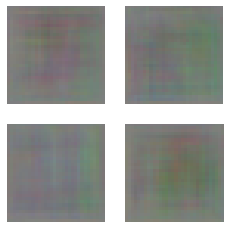

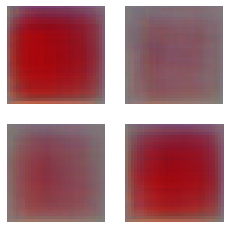

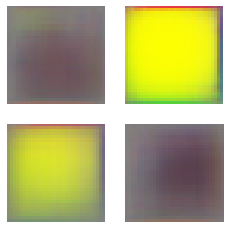

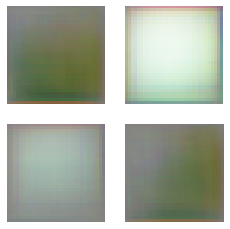

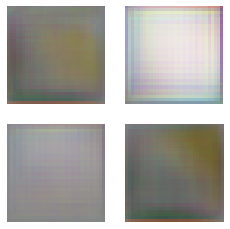

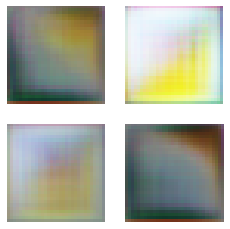

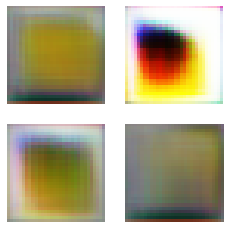

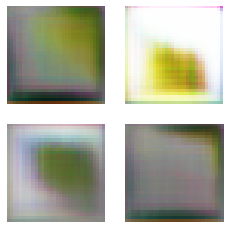

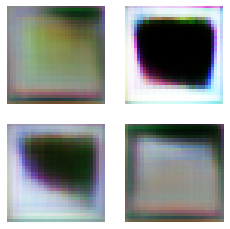

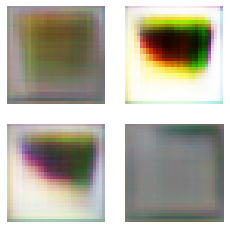

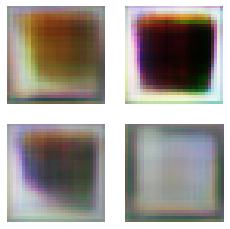

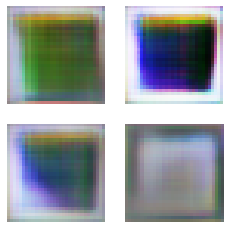

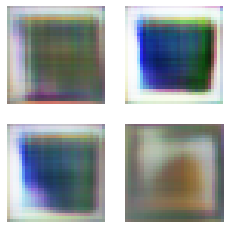

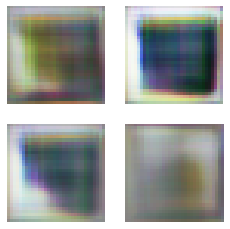

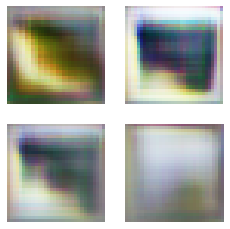

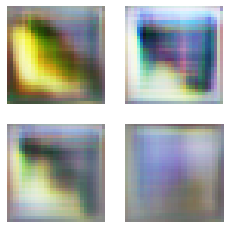

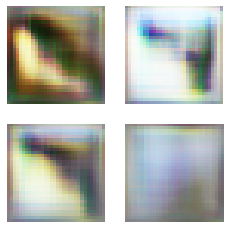

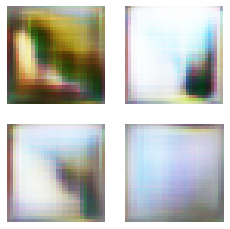

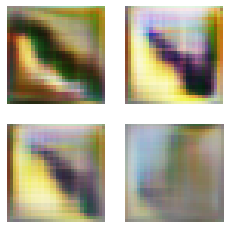

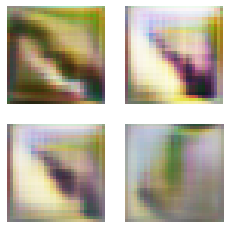

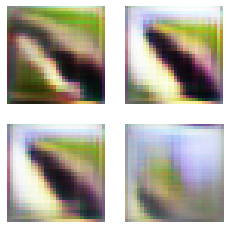

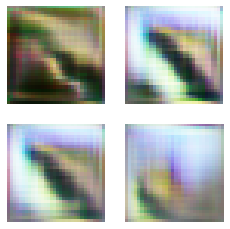

In [13]:
shutil.rmtree('./tb_logs', ignore_errors=True)
shutil.rmtree('./Results', ignore_errors=True)
class GANMonitor(tf.keras.callbacks.Callback):
    def on_batch_end(self, batch, logs):
        if batch % 200 == 0:
            generate_image(self.model, seed=test_seed, isShow=False, isSaveFile=True)
        
mon_cb = GANMonitor()
save_cb = tf.keras.callbacks.ModelCheckpoint('./Checkpoints/', verbose=1)
board_cb = tf.keras.callbacks.TensorBoard( log_dir='./tb_logs/', write_images=True, update_freq='batch') 
gan_model.fit(ds, epochs=epochs, shuffle=True, callbacks=[board_cb, mon_cb])

%% ======= testing =================

In [ ]:
import glob
import imageio

In [ ]:
def create_gif():
    with imageio.get_writer('./Results/result.gif', mode='I') as writer:
        filenames = glob.glob('./Results/*.png')
        filenames = sorted(filenames)
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)
create_gif()